# STAYSL Walk-through NIF
This example walks through the 
Passive 18x snout on TANDM 90-348 NIF Foil Activation Experiment performed by
Energetic Neutron Platform Working Group and NIF Radiochemistry Group

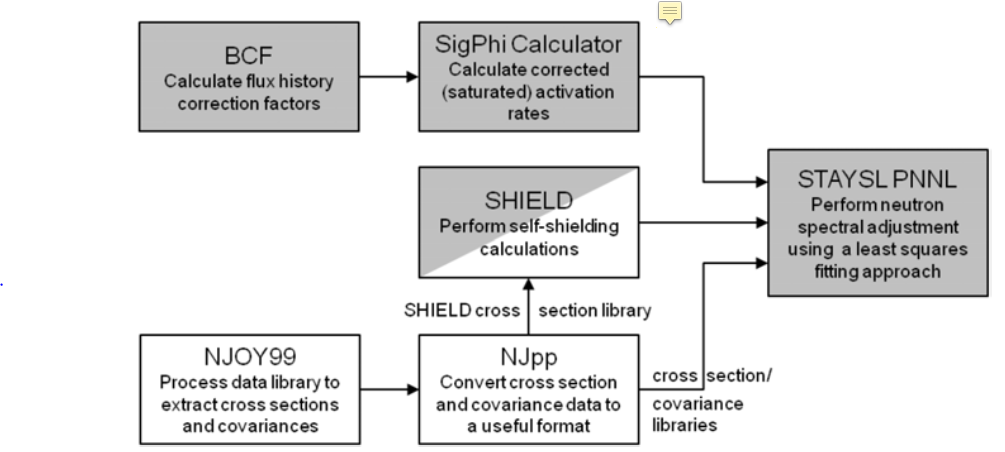
- This is from EPJWeb of Conferences 106, 07001 (2016) Least-Squares Neutron Spectral Adjustment with STAYSL PNNL L.R. Greenwooda and C.D. Johnson

# BCF - Beam Correction Factor
BCF corrects for irradiation history. The calculations performed correct for production and decay during the irradiation. At constant power or flux, this is a simple process 

$A_{0}=A_{\infty}*(1-exp(-\lambda*t))$

BCF normalizes the irradiation history to the time-weighted average reactor power or beam current. A correction factor is produced based on the irradiation hisotry for each isotope of interest. 

For the NIF, this module is not needed, BCF is not needef for a short irradiation time

## SHIELD
The SHIELD code calculates energy-dependent neutron self-shielding cross section correction factors that are used, prior to neutron spectral adjustment, to shield the neutron activation cross sections used by the STAYSL PNNL code. 

SHIELD was performed on ["shldinputNIF.dat"](https://github.com/nickquartemont/NENG612/tree/master/NIF_Unfold/Unfold/SHIELD/shldinputNIF.dat). 

After a painstaking process of trial and error. It was determined that my executable of the SHIELD.exe can only be ran if: 
- Run command prompt as an administrator
- Use runExample batch file with filename replaced with desired input

I am unsure of why it requires this, I am guessing it is a permissions issue that I cannot work out. 

SHIELD is only necessary/valid on non-threshold reactions (n,gamma). SHIELD is dependent on the thickness of the material, so it must be re-ran if different foils/wires are used. 

An output file is created in the same directory shldinput.out

All foils are 1 mm (39.3701 mils) except for the Au foils, which are 0.1 mm

The output is renamed sshldlib.dat


## SigPhi Calculator

The [SigPhi Calculator](https://github.com/nickquartemont/NENG612/tree/master/NIF_Unfold/Unfold/SIGPHI/SigPhi_Calculator_NIF.xlsm) was filled in with data from the [foil and activity information] (https://github.com/nickquartemont/NENG612/tree/master/NIF_Unfold/ActivationData.xlsx)


The purpose of the SigPhi Calculator software is to calculate corrected saturated neutron activation rates from measured activities. These reaction rates, the so-called sig-phi values, represent the product of the spectral-averaged neutron activation cross section and the total neutron flux

The NIF is a very prompt output (~200 ps). There will be some downscatter which may slow a portion down. However, for the purposes of the irradiation, the irradiation time is taken as 1 second, and the reaction rates are taken as per second. This will not impact the results because the half-lives of the measured products are orders of magnitude different from this result. 

The export to excel did not work. Instead, the input was built-up using the calculated gamma shielding and At/At-s from the foil and activity information sheet

I couldn't get the SigPhi Calculator to work for me. I redownloaded everything and it gives me: 
￿￿￿￿￿￿￿￿￿￿ when I try to export to a STAYSL script. 

The sig-phi is calculated by dividing the number of nuclei created at t0 by the total number of atoms present in the foil. This is the relative production. 

The self-shielding factor for gammas is divided by this to correct for gamma self-shielding


# STAYSL

The STAYSL input deck was made with the SIG_PHI calculator and foil/activation data. 

The default values (From examples distributed with STAYSL) for Gaussian formalism were used. 

An iterative solution was performed on the input data and sets the uncertainty below 3 MeV to 100%. This was chosen because the model did not predict the down-scattering well. The baseline guess spectrum was developed using an Appelbe source split with a 14.03 MeV neutron peak at 10.75 keV temperature (See foil/activation Excel doc)

In [1]:
import sys
import os
sys.path.insert(0,os.path.abspath('C:/Users/nickq/Documents/AFIT_Masters/PyScripts/src'))


STAYSL is ran by executing the executable from the command line

# Pinhole Results

In [2]:
import pandas as pd
from DataAnalysis.DataManipulation import bin_integration, bin_differentiation

path = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/stayslin.out'
df = pd.read_table(path, engine='python', sep='\s+', skiprows=101, skipfooter=649, header=None,
                   names=['lowE', 'adjFlux', 'unadjFlux', 'fluxRatio', 'adjStd', 
                          'unadjStd', 'uncertRatio', 'integralFlux', 'intFluxUncert'])

df.apply(pd.to_numeric)

df['adjFlux'] = bin_integration(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low')
df['adjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low', True)
df['unadjFlux'] = bin_integration(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low')
df['unadjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low', True)

df['adjLethargyStd'] = df['adjStd'] * df['adjLethargy'] / 100
df['unadjLethargyStd'] = df['unadjStd'] * df['adjLethargy'] / 100
df['adjStd'] = df['adjStd'] * df['adjFlux'] / 100
df['unadjStd'] = df['unadjStd'] * df['unadjFlux'] / 100

df

,lowE,adjFlux,unadjFlux,fluxRatio,adjStd,unadjStd,uncertRatio,integralFlux,intFluxUncert,adjLethargy,unadjLethargy,adjLethargyStd,unadjLethargyStd
23,0.000069,2.061438e+07,2.181098e+07,0.945,2.015674e+07,2.181098e+07,0.978,4.211300e+12,3.65,5.555483e+07,5.877961e+07,5.432151e+07,5.555483e+07
24,0.000100,2.010400e+07,2.134860e+07,0.942,1.957728e+07,2.134860e+07,0.974,4.211200e+12,3.65,6.698998e+07,7.113720e+07,6.523484e+07,6.698998e+07
25,0.000135,1.837535e+07,1.957725e+07,0.939,1.781858e+07,1.957725e+07,0.970,4.211200e+12,3.65,7.971134e+07,8.492512e+07,7.729609e+07,7.971134e+07
26,0.000170,2.111050e+07,2.255700e+07,0.936,2.038008e+07,2.255700e+07,0.965,4.211200e+12,3.65,8.187788e+07,8.748818e+07,7.904490e+07,8.187788e+07
27,0.000220,2.222280e+07,2.380440e+07,0.934,2.135611e+07,2.380440e+07,0.961,4.211200e+12,3.65,9.214882e+07,9.870707e+07,8.855502e+07,9.214882e+07
28,0.000280,2.430160e+07,2.608320e+07,0.932,2.324448e+07,2.608320e+07,0.956,4.211200e+12,3.65,9.669799e+07,1.037871e+08,9.249163e+07,9.669799e+07
29,0.000360,2.103210e+07,2.260890e+07,0.930,2.001835e+07,2.260890e+07,0.952,4.211100e+12,3.65,9.425368e+07,1.013200e+08,8.971065e+07,9.425368e+07
30,0.000450,2.475875e+07,2.664125e+07,0.929,2.344158e+07,2.664125e+07,0.947,4.211100e+12,3.65,1.010056e+08,1.086855e+08,9.563214e+07,1.010056e+08
31,0.000575,2.963145e+07,3.190325e+07,0.929,2.789505e+07,3.190325e+07,0.941,4.211100e+12,3.65,1.062256e+08,1.143697e+08,1.000007e+08,1.062256e+08
32,0.000760,2.532200e+07,2.726600e+07,0.929,2.368873e+07,2.726600e+07,0.935,4.211100e+12,3.65,1.083921e+08,1.167135e+08,1.014008e+08,1.083921e+08


Plot first result

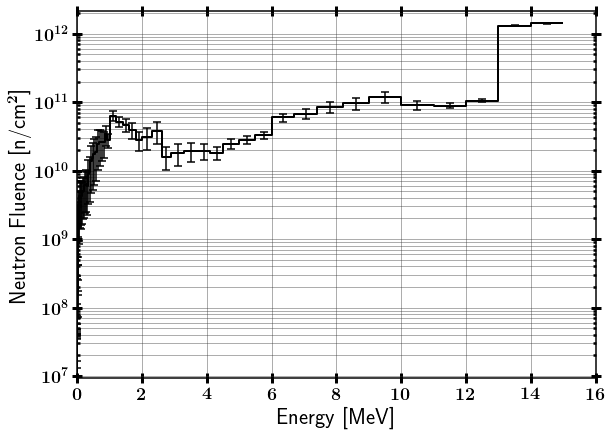

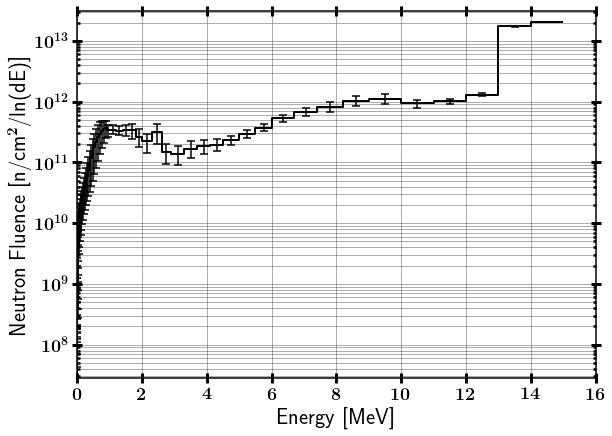

In [3]:
from DataAnalysis.Histograms import Histogram
import matplotlib
%matplotlib inline

outpath ='C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/'
adjHisto = Histogram()
adjHisto.build_histo(df['lowE'].tolist(), df['adjFlux'].tolist(), uncert=df['adjStd'].tolist(),
                     edgeLoc='low')

adjHisto.plot(xMin=1E-6, logX=False, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                  savePath=outpath+'Pin1',includeMarkers=False,
                  legend=False)
adjLethargyHisto = Histogram()
adjLethargyHisto.build_histo(df['lowE'].tolist(), df['adjLethargy'].tolist(), uncert=df['adjLethargyStd'].tolist(),
                     edgeLoc='low')

adjLethargyHisto.plot( xMin=1E-6, logX=False, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$/ln(dE)]',
                  savePath=outpath+'Pin1d_Lethargic',includeMarkers=False,
                  legend=False)

# Iterative Solution: Method 1
  - The iterative solution sets the uncertainty below 3 MeV to 100%.
  - It does not update the uncertainty until $\chi^2$ converged.

In [4]:
from Unfolding.STAYSL import IterativeSTAYSL

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=True, chiConv=0.1))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/
$\chi^2$ Convergence: 0.1
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: True
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/stayslin.out
Chi^2 = 21.42177, Std Norm = 7.14674254119
Chi^2 = 2479.36606
Chi^2 = 1622.58108
Chi^2 = 1775.22273
Chi^2 = 1728.49285
Chi^2 = 1749.55454
Chi^2 = 1736.16813
Chi^2 = 1745.70343
Chi^2 = 1738.72428
Chi^2 = 1743.64466
Chi^2 = 1739.98447
Chi^2 = 1742.9396
Chi^2 = 1740.84094
Chi^2 = 1742.32012
Chi^2 = 1741.47813
Chi^2 = 1741.61171
Chi^2 = 1741.44265
Chi^2 = 1741.6752
Chi^2 = 1741.35329
Chi^2 = 1741.73206
Chi^2 = 1741.36244
Chi^2 = 1741.7242
Chi^2 = 1741.67815
Std Norm = 7.13941517493, 7.13943026789


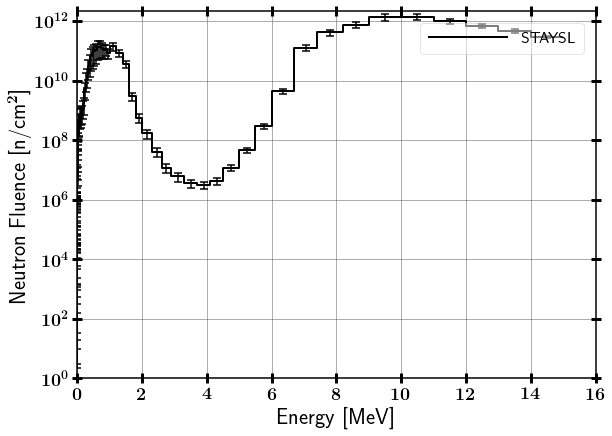

In [6]:
iter = 0
iterAdjHisto[iter].build_histo(iterSoln[iter]._df['lowE'].tolist(),iterSoln[iter]._df['adjFlux'].tolist(),
                             uncert=(iterSoln[iter]._df['adjStd']*iterSoln[iter]._df['adjFlux']).tolist(),
                             edgeLoc='low', name='STAYSL')

iterAdjHisto[iter].plot(xMin=1E-6, xMax=16, yMin=1, logX=False, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                        savePath=outpath+'PIN-Unfold_Itr{:1d}'.format(iter))


# Iterative Method 2:

  - The iterative solution sets the uncertainty below 3 MeV to 100%.
  - It does update the uncertainty throughout the convergence process.

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration2/
$\chi^2$ Convergence: 0.1
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: True
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration2/stayslin.out
Chi^2 = 21.42177, Std Norm = 7.14674254119
Chi^2 = 2479.36606
Chi^2 = 1622.58108
Chi^2 = 1775.22273
Chi^2 = 1728.49285
Chi^2 = 1749.55454
Chi^2 = 1736.16813
Chi^2 = 1745.70343
Chi^2 = 1738.72428
Chi^2 = 1743.64466
Chi^2 = 1739.98447
Chi^2 = 1742.9396
Chi^2 = 1740.84094
Chi^2 = 1742.32012
Chi^2 = 1741.47813
Chi^2 = 1741.61171
Chi^2 = 1741.44265
Chi^2 = 1741.6752
Chi^2 = 1741.35329
Chi^2 = 1741.73206
Chi^2 = 1741.36244
Chi^2 = 1741.7242
Chi^2 = 1741.67815
Std Norm = 7.13941517493, 7.13943026789


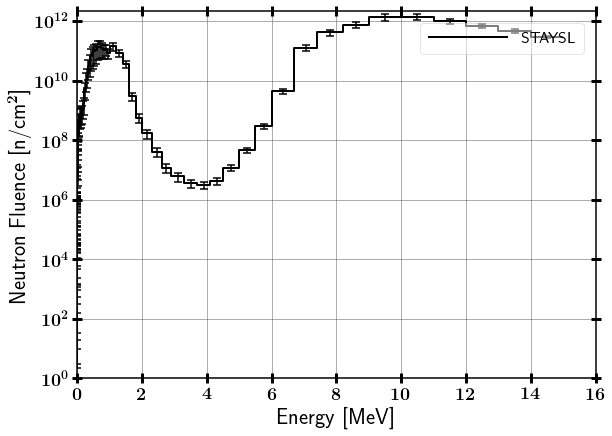

In [7]:
from Unfolding.STAYSL import IterativeSTAYSL

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration2/'

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=True, chiConv=0.1))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())
iter = 1

iterAdjHisto[iter].build_histo(iterSoln[iter]._df['lowE'].tolist(),iterSoln[iter]._df['adjFlux'].tolist(),
                             uncert=(iterSoln[iter]._df['adjStd']*iterSoln[iter]._df['adjFlux']).tolist(),
                             edgeLoc='low', name='STAYSL')

iterAdjHisto[iter].plot(xMin=1E-6, xMax=16, yMin=1, logX=False, logY=True, includeMarkers=False,
              xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                        savePath=outpath+'PIN-Unfold_Itr{:1d}'.format(iter))

# Iterative Method 3:

  - No modifications are made to the MCNP results for the guess spectrum
  - It does update the uncertainty throughout the convergence process. 

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration3/
$\chi^2$ Convergence: 1
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: True
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration3/stayslin.out
Chi^2 = 21.42177, Std Norm = 7.14674254119
Chi^2 = 2479.36606
Chi^2 = 1622.58108
Chi^2 = 1775.22273
Chi^2 = 1728.49285
Chi^2 = 1749.55454
Chi^2 = 1736.16813
Chi^2 = 1745.70343
Chi^2 = 1738.72428
Chi^2 = 1743.64466
Chi^2 = 1739.98447
Chi^2 = 1742.9396
Chi^2 = 1740.84094
Chi^2 = 1742.32012
Chi^2 = 1741.47813
Std Norm = 7.13942323231, 7.13951095034


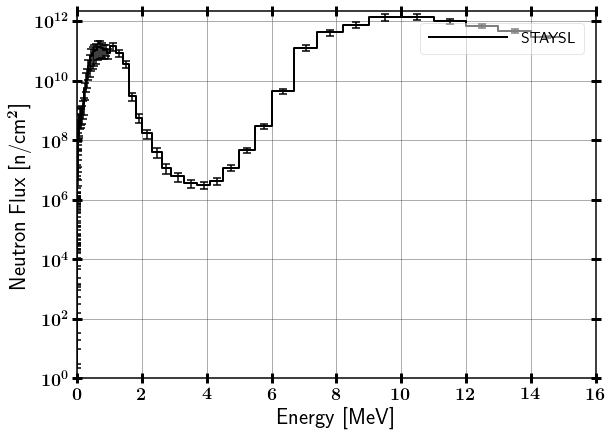

In [9]:
from Unfolding.STAYSL import IterativeSTAYSL

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration3/'
iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=True, chiConv=1))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())
iter = 2

iterAdjHisto[iter].build_histo(iterSoln[iter]._df['lowE'].tolist(),iterSoln[iter]._df['adjFlux'].tolist(),
                             uncert=(iterSoln[iter]._df['adjStd']*iterSoln[iter]._df['adjFlux']).tolist(),
                             edgeLoc='low', name='STAYSL')

iterAdjHisto[iter].plot(xMin=1E-6, xMax=16, yMin=1, logX=False, logY=True, includeMarkers=False,
              xLabel='Energy [MeV]', yLabel='Neutron Flux [n/cm$^2$]',
                        savePath=outpath+'PIN-Unfold_Itr{:1d}'.format(iter))